In [711]:
from src.helper import prepare_df

In [712]:
df = prepare_df()
df.head()

/Users/karimzahra/Desktop/ada-2022-project-lad3k/src/helper.py:6: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



,averageRating,numVotes,directors,writers,primaryTitle,isAdult,release_year,runtimeMinutes,genres,overview,providers,budget,revenue,production_companies,production_countries,on_netflix,on_prime
imdb_id,,,,,,,,,,,,,,,,,
tt0002199,5.8,596,nm0646058,nm0310155,From the Manger to the Cross,0,1912.0,60.0,"Biography,Drama",The life of Jesus is played out in tableaux sh...,"(Amazon Prime Video, Paramount Plus, Paramount...",0,0,['Kalem Company'],['US'],False,True
tt0003973,5.8,265,nm0237713,"nm0078442,nm0348348,nm0612348,nm0715097",A Florida Enchantment,0,1914.0,63.0,Comedy,A young woman discovers a seed that can make w...,"(Amazon Prime Video, Paramount Plus, Epix Roku...",0,0,['Vitagraph Company of America'],['US'],False,True
tt0004457,5.5,499,nm0531759,nm0000875,The Patchwork Girl of Oz,0,1914.0,81.0,"Adventure,Comedy,Family","Ojo and Unc Nunkie are out of food, so they de...","(Amazon Prime Video, Paramount Plus, Paramount...",0,0,['The Oz Film Manufacturing Company'],['US'],False,True
tt0004873,6.1,529,nm0950148,"nm0140902,nm0950148",Alice in Wonderland,0,1915.0,52.0,"Adventure,Family,Fantasy",Alice goes with her sister to a picnic and the...,"(Amazon Prime Video, EPIX Amazon Channel)",0,0,['Nonpareil Feature Film Corp.'],['US'],False,True
tt0005078,6.5,2597,nm0001124,"nm0877318,nm0534221",The Cheat,0,1915.0,59.0,"Drama,Romance","A venal, spoiled stockbroker's wife impulsivel...","(Amazon Prime Video, EPIX Amazon Channel, DIRE...",17311,137365,"['Paramount', 'Jesse L. Lasky Feature Play Com...",['US'],False,True


As of April 2022, there are 4901 movies on netflix, we have 2915 movies in the dataset thus we can estimate
that we are capturing about 60% of the movies on the streaming service.
For Prime there are 6985 movies and we have 6981 so we are capturing about 99.9%.

*[source](https://blog.reelgood.com/which-streaming-service-offers-the-best-bang-for-your-buck)*

![movies](data/movies_ss.png)

Can also check for quality movies and high quality movies the fraction of movies that are in the dataset.

### Movies on Netflix and Prime (US)
- Plot the genre distribution of movies on Netflix and Prime
- Plot the production companies
- Plot the production countries
- Plot the directors and wirters
- Plot the release year
- Plot the runtime
- Plot the average rating


In [713]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import numpy as np
import plotly.express as px

In [714]:
df['streaming_service'] = ['both' if netflix and prime else 'netflix' if netflix
                           else 'prime' for netflix, prime in zip(df['on_netflix'], df['on_prime'])]

In [715]:
df.shape

(9825, 18)

In [716]:
# get dataframe with streaminung service = both
df_both = df[df['streaming_service'] == 'both']
df_both.shape

(74, 18)

>It's very rare to find a movie that's on both platforms

In [717]:
# get movies on netflix and prime 
netflix_movies = df[df['on_netflix'] == True]
prime_movies = df[df['on_prime'] == True]

In [718]:
# get unique genres function
def get_unique_genres(df):
    genres = set(df['genres'].apply(lambda x: x.split(',')).sum())
    genres = list(genres)
    return genres

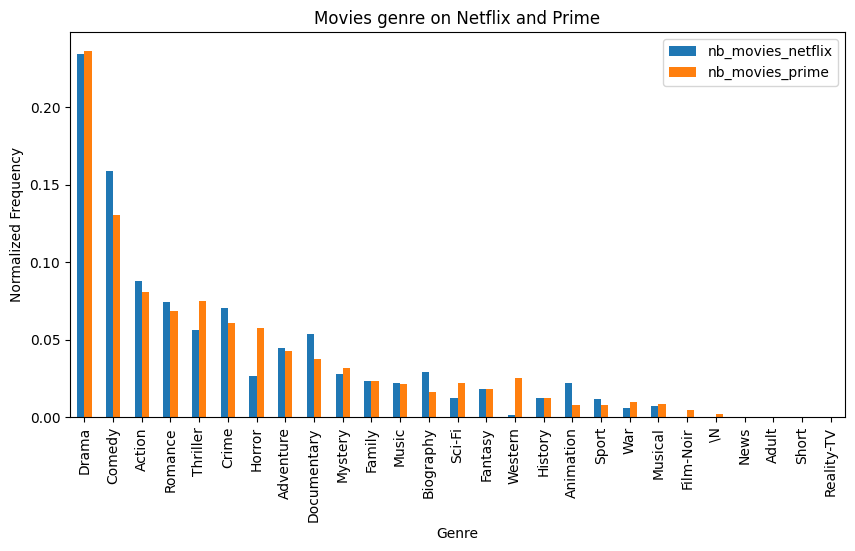

In [719]:
netflix_genres = get_unique_genres(netflix_movies)
movies_genre = {}
for genre in netflix_genres:
    movies_genre[genre] = netflix_movies['genres'].apply(lambda x: genre in x).sum()
netflix_genre = pd.DataFrame.from_dict(
    movies_genre, orient='index', columns=['nb_movies'])

prime_genres = get_unique_genres(prime_movies)
movies_genre = {}
for genre in prime_genres:
    movies_genre[genre] = prime_movies['genres'].apply(lambda x: genre in x).sum()
prime_genre = pd.DataFrame.from_dict(
    movies_genre, orient='index', columns=['nb_movies'])

# join the two dataframes without losing the genres
both_genre = netflix_genre.join(prime_genre, how='outer', lsuffix='_netflix', rsuffix='_prime')
both_genre = both_genre.fillna(0)

# create a new column with the normalized sum of movies on netflix and prime
both_genre['total_movies'] = (both_genre['nb_movies_netflix'] + both_genre['nb_movies_prime'])/ (both_genre[
    'nb_movies_netflix'].sum() + both_genre['nb_movies_prime'].sum())

# normalize the number of movies
both_genre['nb_movies_netflix'] = both_genre['nb_movies_netflix'] / both_genre['nb_movies_netflix'].sum()
both_genre['nb_movies_prime'] = both_genre['nb_movies_prime'] / both_genre['nb_movies_prime'].sum()


both_genre = both_genre.sort_values(by='total_movies', ascending=False)
both_genre.drop('total_movies', axis=1, inplace=True)
both_genre.plot(kind='bar', figsize=(10, 5))


plt.title('Movies genre on Netflix and Prime')
plt.xlabel('Genre')
plt.ylabel('Normalized Frequency')
plt.show()





In [720]:
def plot_distribution(df: pd.DataFrame, column: str):
        """
        Plot the distribution on Netflix and Prime

        Args:
                df (pd.DataFrame): The dataframe containing the data,
                must contain the columns 'on_netflix', 'on_prime' and column
        """
        # if needed transform binary 'on_netflix' and 'on_prime' to boolean
        df['on_netflix'] =  df['on_netflix'].astype(bool)
        df['on_prime'] = df['on_prime'].astype(bool)

        # plot the movie rating distribution on Netflix and Prime
        # rating is in column "averageRating"
        # a col "streaming_service" tells us if the movie is on Netflix, Prime or both

        if column == 'averageRating':
                plt.hist(df[df['on_netflix'] == True][column],
                        bins=np.arange(0, 10.1, 0.5),
                        alpha=0.5,
                        density=True,
                        color='C0',
                        label='Netflix')
                plt.axvline(df[df['on_netflix']][column].mean(),
                                color='C0', linestyle='dashed', linewidth=1)
                plt.axvline(df[df['on_netflix']][column].median(),
                                color='C0', linestyle='dotted', linewidth=1)

                plt.hist(df[df['on_prime']][column],
                        bins=np.arange(0, 10.1, 0.5),
                        alpha=0.5,
                        density=True,
                        color='C1',
                        label='Prime')
                plt.axvline(df[df['on_prime']][column].mean(),
                                color='C1', linestyle='dashed', linewidth=1)
                plt.axvline(df[df['on_prime']][column].median(),
                                color='C1', linestyle='dotted', linewidth=1)

                # add legend for hist and mean/median
                legend_elements = [
                        plt.Line2D([0], [0], color='C0', lw=6, label='Netflix'),
                        plt.Line2D([0], [0], color='C1', lw=6, label='Prime'),
                        plt.Line2D([0], [0], color='k', lw=3,
                                linestyle='dashed', label='Mean'),
                        plt.Line2D([0], [0], color='k', lw=3,
                                linestyle='dotted', label='Median')
                ]
                plt.legend(handles=legend_elements, loc='upper right')

                plt.title('Movie rating distribution on Netflix and Prime')
                plt.xlabel('Average rating')
                plt.ylabel('Density')
                plt.show()

        if column == 'runtimeMinutes':
                plt.hist(df[df['on_netflix'] == True][column],
                bins= np.arange(0, 350, 10),
                alpha=0.5,
                density=True,
                color='C0',
                label='Netflix')
                plt.axvline(df[df['on_netflix']][column].mean(),
                                color='C0', linestyle='dashed', linewidth=1)
                plt.axvline(df[df['on_netflix']][column].median(),
                                color='C0', linestyle='dotted', linewidth=1)

                plt.hist(df[df['on_prime']][column],
                bins= np.arange(0, 350, 10),
                alpha=0.5,
                density=True,
                color='C1',
                label='Prime')
                plt.axvline(df[df['on_prime']][column].mean(),
                                color='C1', linestyle='dashed', linewidth=1)
                plt.axvline(df[df['on_prime']][column].median(),
                                color='C1', linestyle='dotted', linewidth=1)

                # add legend for hist and mean/median
                legend_elements = [
                        plt.Line2D([0], [0], color='C0', lw=6, label='Netflix'),
                        plt.Line2D([0], [0], color='C1', lw=6, label='Prime'),
                        plt.Line2D([0], [0], color='k', lw=3,
                                linestyle='dashed', label='Mean',),
                        plt.Line2D([0], [0], color='k', lw=3,
                                linestyle='dotted', label='Median')
                ]
                plt.legend(handles=legend_elements, loc='upper right')

                plt.title('Movie run time distribution on Netflix and Prime')
                plt.xlabel('run rime (min)')
                plt.ylabel('Density ')
                plt.show()
        
        if column == 'release_year':
                plt.hist(df[df['on_netflix'] == True][column],
                bins= 20,
                alpha=0.5,
                density=True,
                color='C0',
                label='Netflix',
                log=True)
                plt.axvline(df[df['on_netflix']][column].mean(),
                                color='C0', linestyle='dashed', linewidth=1)
                plt.axvline(df[df['on_netflix']][column].median(),
                                color='C0', linestyle='dotted', linewidth=1)

                plt.hist(df[df['on_prime']][column],
                        bins= 20,
                        alpha=0.5,
                        density=True,
                        color='C1',
                        label='Prime',
                        log=True)
                plt.axvline(df[df['on_prime']][column].mean(),
                                color='C1', linestyle='dashed', linewidth=1)
                plt.axvline(df[df['on_prime']][column].median(),
                                color='C1', linestyle='dotted', linewidth=1)

                # add legend for hist and mean/median
                legend_elements = [
                        plt.Line2D([0], [0], color='C0', lw=6, label='Netflix'),
                        plt.Line2D([0], [0], color='C1', lw=6, label='Prime'),
                        plt.Line2D([0], [0], color='k', lw=3,
                                linestyle='dashed', label='Mean',),
                        plt.Line2D([0], [0], color='k', lw=3,
                                linestyle='dotted', label='Median')
                ]
                plt.legend(handles=legend_elements, loc='upper right')

                plt.title('Movie release year distribution on Netflix and Prime')
                plt.xlabel('release year')
                plt.ylabel('Density ')
                plt.show()

        if column == 'revenue':
                plt.hist(df[df['on_netflix'] == True][column],
                bins= 20,
                alpha=0.5,
                color='C0',
                density=True,
                label='Netflix',
                log=True)
                plt.axvline(df[df['on_netflix']][column].mean(),
                                color='C0', linestyle='dashed', linewidth=1)
                plt.axvline(df[df['on_netflix']][column].median(),
                                color='C0', linestyle='dotted', linewidth=1)

                plt.hist(df[df['on_prime']][column],
                bins= 20,
                alpha=0.5,
                color='C1',
                density=True,
                label='Prime',
                log=True)
                plt.axvline(df[df['on_prime']][column].mean(),
                                color='C1', linestyle='dashed', linewidth=1)
                plt.axvline(df[df['on_prime']][column].median(),
                                color='C1', linestyle='dotted', linewidth=1)

                # add legend for hist and mean/median
                legend_elements = [
                        plt.Line2D([0], [0], color='C0', lw=6, label='Netflix'),
                        plt.Line2D([0], [0], color='C1', lw=6, label='Prime'),
                        plt.Line2D([0], [0], color='k', lw=3,
                                linestyle='dashed', label='Mean',),
                        plt.Line2D([0], [0], color='k', lw=3,
                                linestyle='dotted', label='Median')
                ]
                plt.legend(handles=legend_elements, loc='upper right')

                plt.title('Movies revenues distribution on Netflix and Prime')
                plt.xlabel('revenue ($)')
                plt.ylabel('Density ')
                plt.show()
        
        if column == 'numVotes':
                plt.hist(df[df['on_netflix'] == True][column],
                bins= 20,
                alpha=0.5,
                color='C0',
                density=True,
                label='Netflix',
                log=True)
                plt.axvline(df[df['on_netflix']][column].mean(),
                                color='C0', linestyle='dashed', linewidth=1)
                plt.axvline(df[df['on_netflix']][column].median(),
                                color='C0', linestyle='dotted', linewidth=1)

                plt.hist(df[df['on_prime']][column],
                bins= 20,
                alpha=0.5,
                color='C1',
                density=True,
                label='Prime',
                log=True)
                plt.axvline(df[df['on_prime']][column].mean(),
                                color='C1', linestyle='dashed', linewidth=1)
                plt.axvline(df[df['on_prime']][column].median(),
                                color='C1', linestyle='dotted', linewidth=1)

                # add legend for hist and mean/median
                legend_elements = [
                        plt.Line2D([0], [0], color='C0', lw=6, label='Netflix'),
                        plt.Line2D([0], [0], color='C1', lw=6, label='Prime'),
                        plt.Line2D([0], [0], color='k', lw=3,
                                linestyle='dashed', label='Mean',),
                        plt.Line2D([0], [0], color='k', lw=3,
                                linestyle='dotted', label='Median')
                ]
                plt.legend(handles=legend_elements, loc='upper right')

                plt.title('Movies numner of votes on Netflix and Prime')
                plt.xlabel('number of votes')
                plt.ylabel('Density ')
                plt.show()

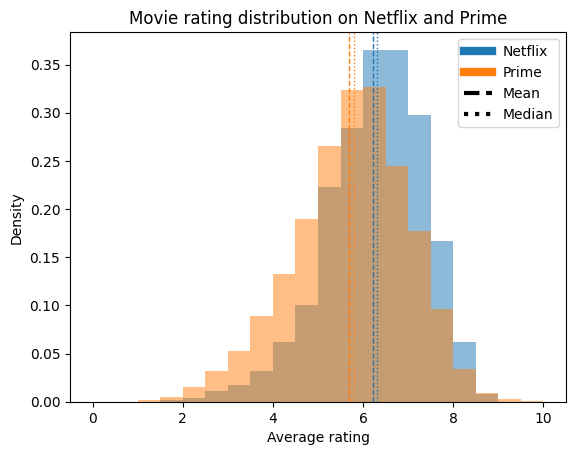

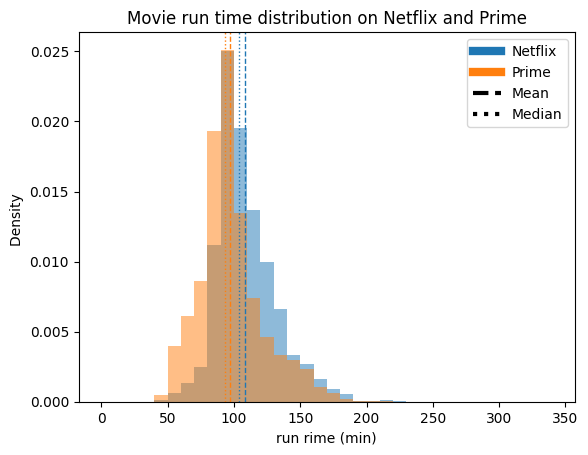

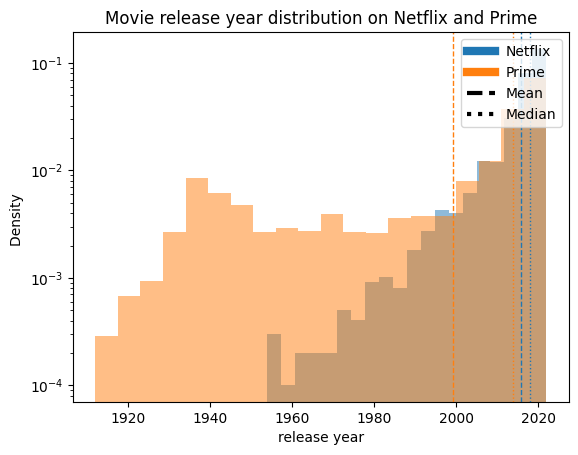

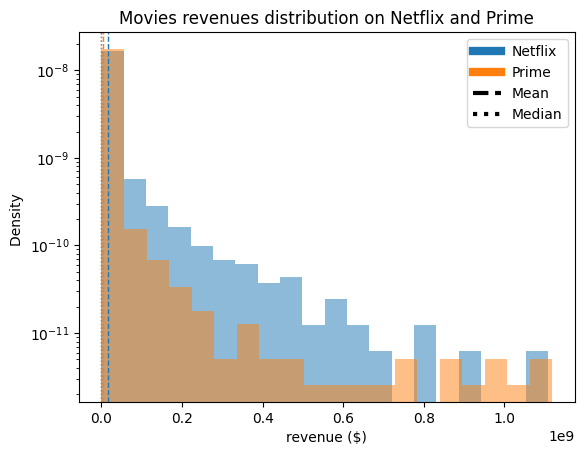

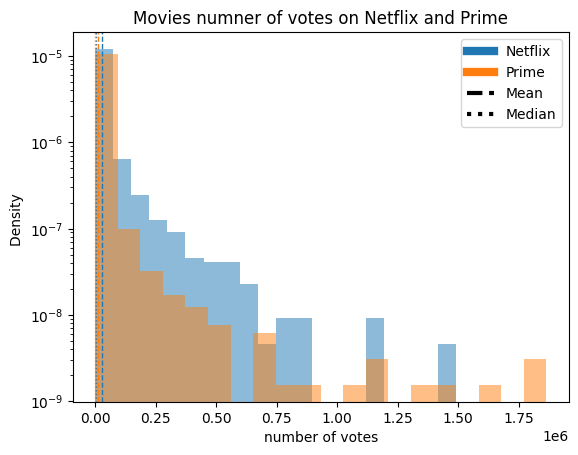

In [721]:
plot_distribution(df, 'averageRating')
plot_distribution(df, 'runtimeMinutes')
plot_distribution(df, 'release_year')
plot_distribution(df, 'revenue')
plot_distribution(df, 'numVotes')


In [722]:
# compare p value of average rating of movies on netflix and prime
ttest_ind(netflix_movies['averageRating'], prime_movies['averageRating'], equal_var=False, alternative='greater')

Ttest_indResult(statistic=20.999390841789367, pvalue=5.35105532777801e-95)

> The pvalue is smaller than 1%. We can reject the null hypothesis of equal means of average ratings of movies on Netflix and Prime. We can even confirm that the mean of the average rating of movies on Netflix is greater than the mean of the avergae rating movies on Prime. Movies on Netfliy are generally higher rated than movies on Prime.

In [723]:
# only movies with runtime > 0
netflix_movies_runtime = netflix_movies[netflix_movies['runtimeMinutes'] > 0]
prime_movies_runtime = prime_movies[prime_movies['runtimeMinutes'] > 0]

ttest_ind(netflix_movies_runtime['runtimeMinutes'], prime_movies_runtime['runtimeMinutes'], equal_var=False, alternative='greater')

Ttest_indResult(statistic=21.349644936740333, pvalue=7.033380333226169e-98)

> The pvalue is smaller than 1%. We can reject the null hypothesis of equal means of running times of movies on Netflix and Prime. We can even confirm that the mean of the running times of movies on Netflix is greater than the mean of the running times of movies on Prime. Movies on Netfliy are generally longer than movies on Prime.

In [724]:
ttest_ind(netflix_movies['release_year'], prime_movies['release_year'], equal_var=False, alternative='greater')

Ttest_indResult(statistic=44.090057532648736, pvalue=0.0)

> The pvalue is smaller than 1%. We can reject the null hypothesis of equal means of release years of movies on Netflix and Prime. We can even confirm that the mean of release years of movies on Netflix is greater than the mean of release years of movies on Prime. Thus movies are generally more recent than movies on prime.

In [725]:
ttest_ind(netflix_movies['revenue'], prime_movies['revenue'], alternative='greater')

Ttest_indResult(statistic=10.15740132870043, pvalue=2.016220974780998e-24)

> The pvalue is smaller than 1%. We can reject the null hypothesis of equal means of revenues movies on Netflix and Prime. We can even confirm that the mean of the revenues of movies on Netflix is greater than the mean of revenues of movies on Prime.

In [726]:
ttest_ind(netflix_movies['numVotes'], prime_movies['numVotes'], alternative='greater')

Ttest_indResult(statistic=12.871157379728789, pvalue=6.546461801814349e-38)

> The pvalue is smaller than 1%. We can reject the null hypothesis of equal means of number of votes for movies on Netflix and Prime. We can even confirm that the mean of the number of votes of movies on Netflix is greater than the mean of revenues of movies on Prime.

In [736]:
prod_countrie_netflix = netflix_movies['production_countries'].apply(lambda x: x.replace('[', '').replace(']', '').replace('"', '').replace(' ', '').replace("'", "").split(',')).sum()
prod_countrie_netflix = pd.Series(prod_countrie_netflix).value_counts(normalize=True)
prod_countrie_prime = prime_movies['production_countries'].apply(lambda x: x.replace('[', '').replace(']', '').replace('"', '').replace(' ', '').replace("'", "").split(',')).sum()
prod_countrie_prime = pd.Series(prod_countrie_prime).value_counts(normalize=True)

df_prod_countrie = pd.concat([prod_countrie_netflix, prod_countrie_prime], axis=1)
df_prod_countrie.columns = ['Netflix', 'Prime']
df_prod_countrie = df_prod_countrie.fillna(0)

# df_prod_countrie to dataframe with columns 'production_countries' and 'Netflix' and 'Prime'
df_prod_countrie = df_prod_countrie.reset_index()
df_prod_countrie.columns = ['production_countries', 'Netflix', 'Prime']




In [737]:
# get df_prod_comp us row values

from pycountry_convert import country_alpha2_to_country_name, country_name_to_country_alpha3

def alpha2_to_country_name(x: str) -> str:
    try:
        country = country_alpha2_to_country_name(x)
        return country
    except KeyError:
        return ""

alpha2_to_country_name('ksk')



In [738]:
df_prod_countrie

,production_countries,Netflix,Prime
0,United States,0.277823,0.435814
1,India,0.135357,0.100400
2,United Kingdom,0.055510,0.059565
3,France,0.041838,0.028097
4,Spain,0.035001,0.010614
...,...,...,...
124,Eswatini,0.000000,0.000125
126,Ecuador,0.000000,0.000125
127,Rwanda,0.000000,0.000125
128,Turks and Caicos Islands,0.000000,0.000125


In [739]:
fig1 = px.choropleth(df_prod_countrie, locations='production_countries', color='Netflix',
                    locationmode='country names', color_discrete_sequence= 'inferno' )

fig2 = px.choropleth(df_prod_countrie, locations='production_countries', color='Prime',
                    locationmode='country names', color_discrete_sequence= 'inferno' )
# # color with circle size
# fig2 = px.choropleth(df_prod_comp, locations='production_countries', color='Prime',
#                     locationmode='country names', color_continuous_scale='inferno')
   


# Show the map
fig1.show()
fig2.show()


<AxesSubplot: title={'center': 'Number of movies per country in Netflix and Prime'}, xlabel='production_countries'>

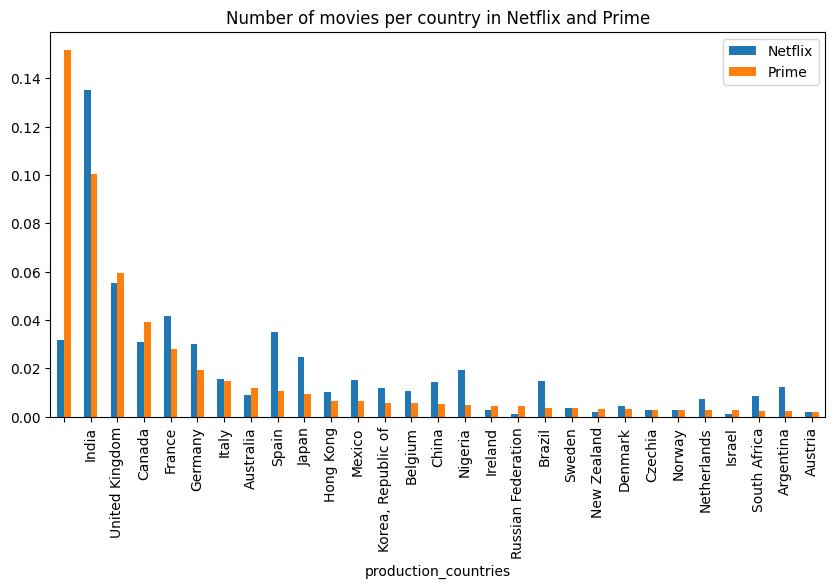

In [751]:
prod_countrie_netflix = netflix_movies['production_countries'].apply(lambda x: x.replace('[', '').replace(']', '').replace('"', '').replace(' ', '').replace("'", "").split(',')).sum()
prod_countrie_netflix = pd.Series(prod_countrie_netflix).value_counts(normalize=True)
prod_countrie_prime = prime_movies['production_countries'].apply(lambda x: x.replace('[', '').replace(']', '').replace('"', '').replace(' ', '').replace("'", "").split(',')).sum()
prod_countrie_prime = pd.Series(prod_countrie_prime).value_counts(normalize=True)

df_prod_countrie = pd.concat([prod_countrie_netflix, prod_countrie_prime], axis=1)
df_prod_countrie.columns = ['Netflix', 'Prime']
df_prod_countrie = df_prod_countrie.fillna(0)

# df_prod_countrie to dataframe with columns 'production_countries' and 'Netflix' and 'Prime'
df_prod_countrie = df_prod_countrie.reset_index()
df_prod_countrie.columns = ['production_countries', 'Netflix', 'Prime']

df_prod_countrie['production_countries'] = df_prod_countrie['production_countries'].apply(lambda x: alpha2_to_country_name(x))

# # remove empty rows
# df_prod_countrie = df_prod_countrie[df_prod_countrie['production_countries'] != '']

df_prod_countrie = df_prod_countrie.sort_values(by='Prime', ascending=False)

# set a column as index
df_prod_countrie = df_prod_countrie.set_index('production_countries')

df_prod_countrie[1:30].plot(kind='bar', title='Number of movies per country in Netflix and Prime', figsize=(10, 5))



<AxesSubplot: title={'center': 'Number of movies per production company in Netflix and Prime'}>

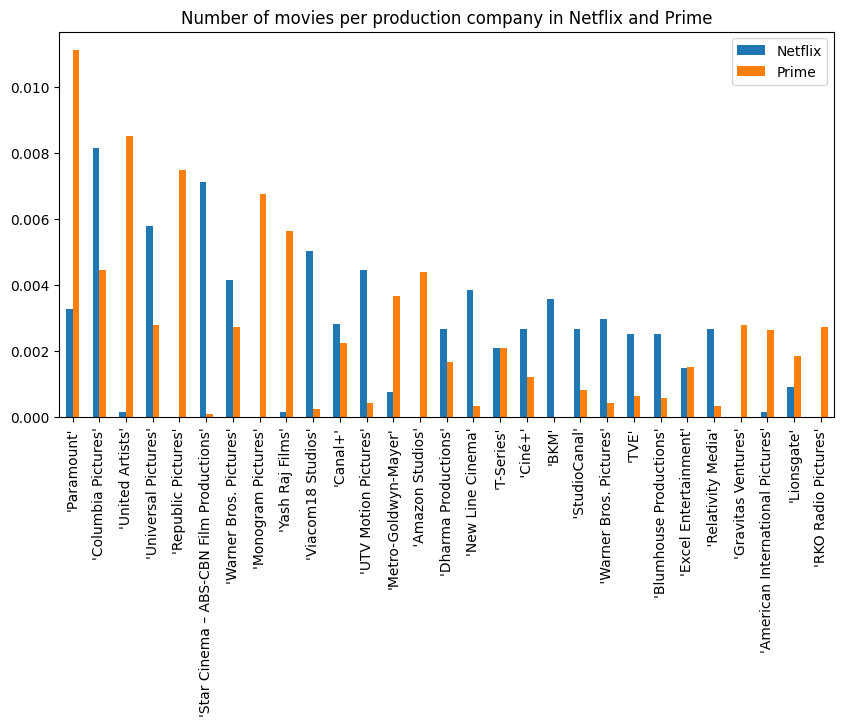

In [742]:
prod_comp_netflix = netflix_movies['production_companies'].apply(lambda x: x.replace('[', '').replace(']', '').replace('"', '').split(',')).sum()
prod_comp_netflix = pd.Series(prod_comp_netflix).value_counts(sort=True, ascending=False, normalize=True)


prod_comp_prime = prime_movies['production_companies'].apply(lambda x: x.replace('[', '').replace(']', '').replace('[]', 'dk').split(',')).sum()
prod_comp_prime = pd.Series(prod_comp_prime).value_counts(sort=True, ascending=False, normalize=True)


# join the two dataframes to compare the production companies
df_prod_comp = pd.concat([prod_comp_netflix, prod_comp_prime], axis=1)
df_prod_comp.columns = ['Netflix', 'Prime']
df_prod_comp = df_prod_comp.fillna(0)

# get the sum of the number of movies per production company
df_prod_comp['sum'] = df_prod_comp['Netflix'] + df_prod_comp['Prime']

# sum over the column 'sum'
df_prod_comp['sum'].sum()

# sort the dataframe by the number of movies on prime
df_prod_comp = df_prod_comp.sort_values(by='sum', ascending=False)

# drop the column 'sum'
df_prod_comp = df_prod_comp.drop(columns=['sum'])

df_prod_comp[1:30].plot(kind='bar', title='Number of movies per production company in Netflix and Prime', figsize=(10, 5))

In [752]:
# df_prod_comp = df_prod_comp[(df_prod_comp['Netflix'] > 0) & (df_prod_comp['Prime'] > 0)]

# df_prod_comp[:20].plot(kind='bar', title='Number of movies per production company in Netflix and Prime', figsize=(10, 5))

> There are 900 production companies in common out of 6286. They have very different prodcution companies.

<AxesSubplot: title={'center': 'Number of movies per writer in Netflix and Prime'}>

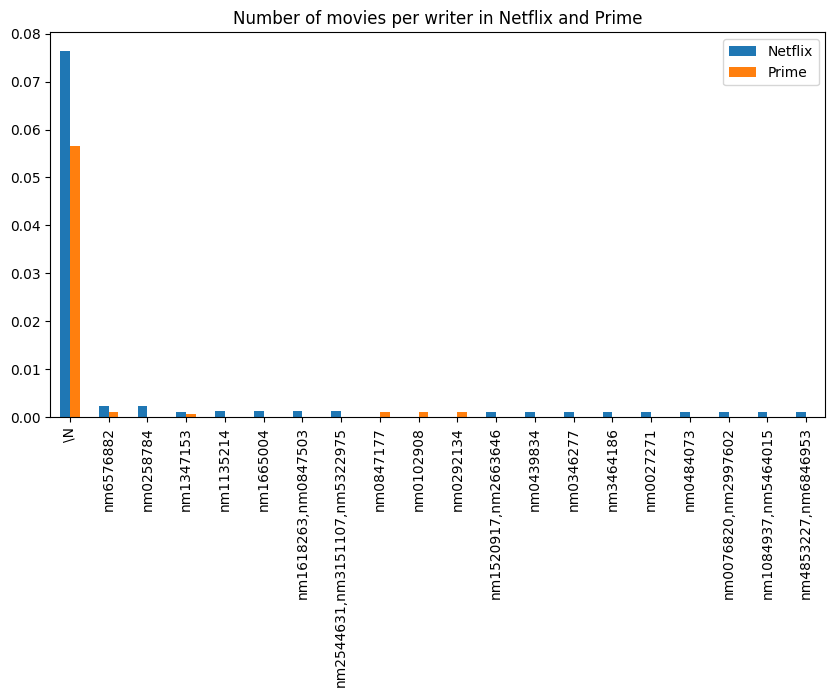

In [753]:
writers_netflix = pd.Series(netflix_movies['writers']).value_counts(sort=True, ascending=False, normalize=True)
writers_prime = pd.Series(prime_movies['writers']).value_counts(sort=True, ascending=False, normalize=True)

df_writers = pd.concat([writers_netflix, writers_prime], axis=1)
df_writers.columns = ['Netflix', 'Prime']
df_writers = df_writers.fillna(0)

# get the sum of the number of movies per production company
df_writers['sum'] = df_writers['Netflix'] + df_writers['Prime']

# sum over the column 'sum'
df_writers['sum'].sum()

# sort the dataframe by the number of movies on prime
df_writers = df_writers.sort_values(by='sum', ascending=False)

# drop the column 'sum'
df_writers = df_writers.drop(columns=['sum'])

df_writers[:20].plot(kind='bar', title='Number of movies per writer in Netflix and Prime', figsize=(10, 5))

<AxesSubplot: title={'center': 'Number of movies per director in Netflix and Prime'}>

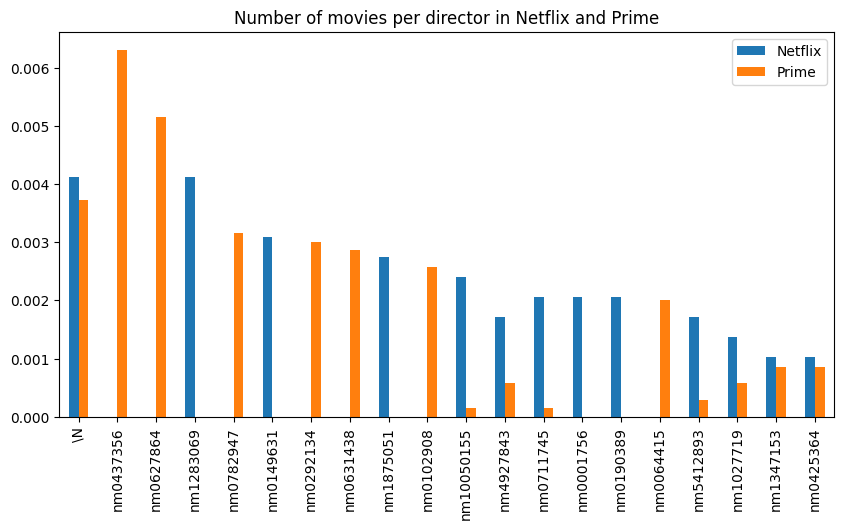

In [754]:
directors_netflix = pd.Series(netflix_movies['directors']).value_counts(sort=True, ascending=False, normalize=True)
directors_prime = pd.Series(prime_movies['directors']).value_counts(sort=True, ascending=False, normalize=True)

df_directors = pd.concat([directors_netflix, directors_prime], axis=1)
df_directors.columns = ['Netflix', 'Prime']
df_directors = df_directors.fillna(0)

# get the sum of the number of movies per production company
df_directors['sum'] = df_directors['Netflix'] + df_directors['Prime']

# sum over the column 'sum'
df_directors['sum'].sum()

# sort the dataframe by the number of movies on prime
df_directors = df_directors.sort_values(by='sum', ascending=False)

# drop the column 'sum'
df_directors = df_directors.drop(columns=['sum'])

df_directors[:20].plot(kind='bar', title='Number of movies per director in Netflix and Prime', figsize=(10, 5))